Original sound


Spectrogram size (freq, time) = (161, 550)
Basements for NMF = 9

Basement 1


Basement 2


Basement 3


Basement 4


Basement 5


Basement 6


Basement 7


Basement 8


Basement 9


Sum all basements (approximation by NMF)


c:\users\whois\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:203: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
c:\users\whois\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:210: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


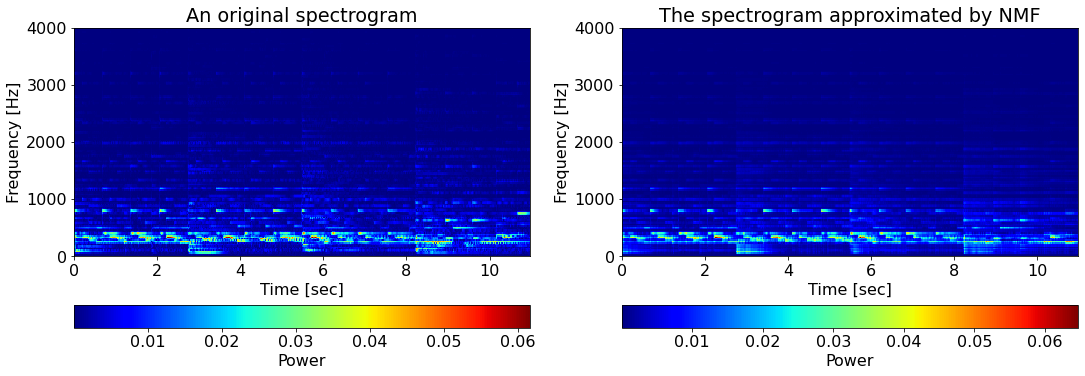

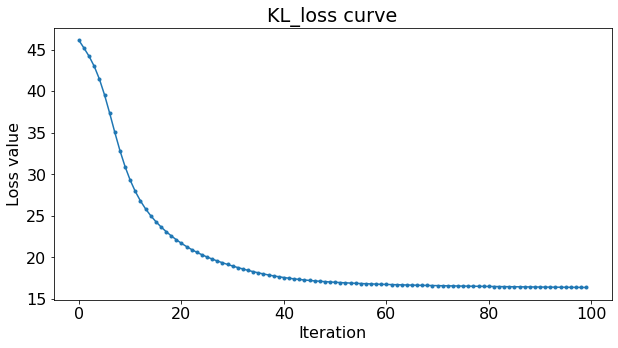

In [5]:
#変分推論により最適化問題を解くことで,入力されたスペクトログラムを限られたスペクトルパターンと時間的強度変化の組み合わせで近似表現する
#非負制約付きの任意基底数による低ランク近似
#X≈HU(H, Uは非負と仮定)

import sys
import soundfile as sf
import IPython.display as ipd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
import numpy as np
from scipy import signal as sg
from scipy import fftpack as fp

#Function for converting images into animation
#def update_anim(i, img):
 #   if i != 0:
  #      plt.cla()
   # plt.pcolormesh(times, freqs, img[i], cmap = 'rainbow')
    #plt.title("Iteration " + str(i+1) + ": the spectrogram approximated by NMF")
    #plt.xlabel('Time [sec]')
    #plt.ylabel('Frequency [Hz]')

#Function for removing components closing to zero
def get_nonzero(mat1, mat2):
    new_mat1 = np.where(mat1 < 1e-10, 1e-10, mat1)
    new_mat2 = np.where(mat2 < 1e-10, 1e-10, mat2)
    product = new_mat1 @ new_mat2
    return new_mat1, new_mat2, product

#Function for getting basements and activation matrix by NMF
def get_NMF(Y, num_iter, num_base, loss_func, save_anime):
    
    #Prepare the drawing area for animation
    plt.rcParams["font.size"] = 16
    if save_anime == True:
        fig = plt.figure(figsize=(12, 8))
    
    #Remove components closing to zero in Y
    Y = np.where(Y < 1e-10, 1e-10, Y)
    
    #Initialize basements and activation based on the Y size(k, n)
    K, N = Y.shape[0], Y.shape[1]
    if num_base >= K or num_base >= N:
        print("The number of basements should be lower than input size.")
        sys.exit()
    H = np.random.rand(K, num_base) #basements      numpyで一様分布の乱数生成(基底行列の事前分布)
    H = H / H.sum(axis=0, keepdims=True) #Normalization
    U = np.random.rand(num_base, N) #activation     numpyで一様分布の乱数生成(アクティベーション行列の事前分布)
    
    #Initialize valuables
    loss = np.zeros(num_iter)
    HU = []
    
    #Repeat num_iter times
    for i in range(num_iter):
        #距離関数は任意
        
        #ユークリッド距離
        if loss_func == "EU":
            #Hの更新
            H, U, X = get_nonzero(H, U)
            H = H * (Y @ U.T) / (X @ U.T)
            H = H / H.sum(axis=0, keepdims=True) #Normalization
            
            #Uの更新
            H, U, X = get_nonzero(H, U)
            U = U * (H.T @ Y) / (H.T @ X)
            
            #損失関数の計算
            H, U, X = get_nonzero(H, U)
            loss[i] = np.sum((Y - X)**2)
        
        #KLダイバージェンス
        elif loss_func == "KL":
            #Hの更新
            H, U, X = get_nonzero(H, U)
            denom_H = U.T.sum(axis=0, keepdims=True) #(1xM) matrix
            H = H * ((Y / X) @ U.T) / denom_H
            H = H / H.sum(axis=0, keepdims=True) #Normalization
            
            #Uの更新
            H, U, X = get_nonzero(H, U)
            denom_U = H.T.sum(axis=1, keepdims=True) #(Mx1) matrix
            U = U * (H.T @ (Y / X)) / denom_U
            
            #損失関数の計算
            H, U, X = get_nonzero(H, U)
            loss[i] = np.sum(Y * np.log(Y / X) - Y + X)
        
        #板倉斎藤擬距離
        elif loss_func == "IS":
            #Hの更新
            H, U, X = get_nonzero(H, U)
            denom_H = np.sqrt(X**-1 @ U.T)
            H = H * np.sqrt((Y / X**2) @ U.T) / denom_H
            H = H / H.sum(axis=0, keepdims=True) #Normalization
            
            #Uの更新
            H, U, X = get_nonzero(H, U)
            denom_U = np.sqrt(H.T @ X**-1)
            U = U * np.sqrt(H.T @ (Y / X**2)) / denom_U
            
            #損失関数の計算
            H, U, X = get_nonzero(H, U)
            loss[i] = np.sum(Y / X - np.log(Y / X) - 1)
        
        else:
            print("The deviation shold be either 'EU', 'KL', or 'IS'.")
            sys.exit()
        
        #Collecting reconstructed image for each iteration
        if save_anime == True:
            HU.append(H @ U)
    
    #Save the images as animation
    if save_anime == True:
        #Pass the H @ U list into "update_anim" and repeat "frames" times
        anime = FuncAnimation(fig, update_anim, fargs=[HU], interval=200, frames=num_iter)
        anime.save('NMF_spectrogram.gif', writer=PillowWriter(fps=5))
        plt.close()
    
    return H, U, loss

#Main
if __name__ == "__main__":
    
    #Setup
    audiolen = None        #Cropping time (second) [Default]None(=without cropping)
    frame_length = 0.04    #窓長(second)
    frame_shift = 0.02     #シフト(second), オーバーラップ半分
    num_iter = 100         #更新回数
    num_base = 9           #基底数
    spec_type = "amp"      #amp or power spectrogram
    loss_func = "KL"       #EU, KL,or IS
    save_anime = False     #Save the reconstructed spectrogram for each iteration as anime
    
    #入力
    data, Fs = sf.read("./ES_Piano_175_19_E.wav")
    
    #Transform stereo into monoral
    if data.ndim == 2:
        wavdata = 0.5*data[:, 0] + 0.5*data[:, 1]
    else:
        wavdata = data
        
     #サンプリング周波数
    wavdata = sg.resample_poly(wavdata, 8000, Fs)
    Fs = 8000
    
    #入力音源
    print("Original sound")
    ipd.display(ipd.Audio(data=wavdata, rate=Fs))
    
    #窓長/オーバーラップ
    FL = round(frame_length * Fs)
    FS = round(frame_shift * Fs)
    OL = FL - FS
    
    #短時間フーリエ変換
    freqs, times, dft = sg.stft(wavdata, fs=Fs, window='hamm', nperseg=FL, noverlap=OL)
    arg = np.angle(dft)                #Preserve the phase
    Adft = np.abs(dft)                 #Preserve the absolute amplitude
    if spec_type == "amp":            #振幅スペクトログラム
        Y = Adft
    elif spec_type == "pow":          #パワースペクトログラム
        Y = Adft**2
    else:
        print("The spec_type must be either 'amp' or 'pow'.")
        sys.exit()
    
    #Display the size of input
    print("Spectrogram size (freq, time) = " + str(Y.shape))
    print("Basements for NMF = " + str(num_base) + "\n")
    
    #Call my function for updating NMF basements and activation
    H, U, loss = get_NMF(Y, num_iter, num_base, loss_func, save_anime)
    
    
    #基底ベクトル
    #特定列の基底ベクトル以外を0にした行列を順次作り、右からアクティベーション行列をかける
    for j in range(num_base):
        zero_mat = np.zeros((H.shape[1], H.shape[1]))
        zero_mat[j, j] = 1
        Base = (H @ zero_mat) @ U #Extract an only dictionary
        Base = Base * np.exp(1j*arg) #Restrive the phase from original wave
        _, Base_wav = sg.istft(Base, fs=Fs, window='hamm', nperseg=FL, noverlap=OL) #back to the time domain
        print("Basement " + str(j+1))
        ipd.display(ipd.Audio(data=Base_wav, rate=Fs))
        if j ==0:
            Sum_wav = Base_wav
        else:
            Sum_wav = Sum_wav + Base_wav    #設定した数の基底ベクトルをすべて用いたときの近似結果
    print("Sum all basements (approximation by NMF)")
    ipd.display(ipd.Audio(data=Sum_wav, rate=Fs))
    
    #スペクトログラム表示
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 2, 1)
    plt.title('An original spectrogram')
    plt.xlabel('Time [sec]')
    plt.ylabel('Frequency [Hz]')
    plt.pcolormesh(times, freqs, Y, cmap = 'jet')
    plt.colorbar(orientation='horizontal').set_label('Power')
    
    plt.subplot(1, 2, 2)
    plt.title('The spectrogram approximated by NMF')
    plt.xlabel('Time [sec]')
    plt.ylabel('Frequency [Hz]')
    plt.pcolormesh(times, freqs, (H @ U), cmap = 'jet')
    plt.colorbar(orientation='horizontal').set_label('Power')
    
    #学習曲線のグラフ表示
    plt.figure(figsize=(10, 5))
    plt.plot(np.arange(num_iter)[:], loss[:], marker='.')
    plt.title(loss_func + '_loss curve')
    plt.xlabel('Iteration')
    plt.ylabel('Loss value')